# HW8.1: Segmented Skin Cancer Image Classification using DL models & techniques with Keras
---
###### Name: Devson Butani
###### ID: 000732711
###### LTU Honor Code: "I pledge that on all academic work that I submit, I will neither give nor receive unauthorized aid, nor will I present another person's work as my own."

# Get dataset from `Google Drive`

In [1]:
# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# # Change directory to a drive folder of choice - Runs and models will be saved here
# %cd '/content/drive/MyDrive/DL_data'
%pwd # Verify

'/Users/cedar/Downloads/HW8'

In [2]:
train_dir = "skin_cancer/train"
vali_dir = "skin_cancer/validation"
test_dir = "skin_cancer/test"

train_benign_dir = "skin_cancer/train/benign"
train_malignant_dir = "skin_cancer/train/malignant"
vali_benign_dir = "skin_cancer/validation/benign"
vali_malignant_dir = "skin_cancer/validation/malignant"
test_benign_dir = "skin_cancer/test/benign"
test_malignant_dir = "skin_cancer/test/malignant"

import os, shutil

print("total training benign images:", len(os.listdir(train_benign_dir)))
print("total training malignant images:", len(os.listdir(train_malignant_dir)))
print("total validation benign images:", len(os.listdir(vali_benign_dir)))
print("total validation malignant images:", len(os.listdir(vali_malignant_dir)))
print("total test benign images:", len(os.listdir(test_benign_dir)))
print("total test malignant images:", len(os.listdir(test_malignant_dir)))

total training benign images: 1000
total training malignant images: 852
total validation benign images: 300
total validation malignant images: 218
total test benign images: 140
total test malignant images: 127


Dataset seems to be mostly balanced with a slight bias towards the benign class.

# Install Dependencies

In [3]:
# %pip install comet_ml --quiet
# %pip install pillow
# %pip install matplotlib

# Initialize `Comet` for datalogging

In [4]:
import comet_ml

comet_ml.config.save(api_key="mQStuXAxGmHmK1vOsTRucvz76")  # Insert API key from comet user account
comet_ml.init(project_name="HW8_Skin_Cancer_Classification")

COMET ERROR: '/Users/cedar/.comet.config' exists and force is not True; refusing to overwrite


# Import Dependencies

In [5]:
import numpy as np
from tensorflow import keras
import tensorflow as tf
from keras import layers
from keras import models
from keras import optimizers

In [6]:
# Check if GPU available and linked to tensorflow so that keras can use it
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


# Setup Data Generator and Augmentation

In [7]:
from keras.preprocessing.image import ImageDataGenerator

img_size = (150, 150)  # Need to investigate why 224x224 is lower accuracy. Maybe layer size?

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Rescale the pixel values from [0-255] to [0, 1] for easier NN processing
    # rotation_range=15,  # Full range, samples may not be orientation normalized
    # width_shift_range=0.05,  # lateral shift
    # height_shift_range=0.05,  # vertical shift
    # shear_range=0.1, # Small because most samples are taken flat to surface. Does not improve performance
    # zoom_range=0.02,  # zoom can vary in real-life samples.
    horizontal_flip=True, # Try with or without. Without is better accuracy
    fill_mode="nearest",
)
# ^^^ DA improvement is less than 5% but helps curb overfitting for 10-15 more epochs
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,  # All images will be resized to 224x224
    batch_size=18,  # Use default batch size 32? 18 is better for the this Mac Pro's GPU
    shuffle=False,  # default is True
    class_mode="binary",
)  # Binary classification problem. Benign or malignant

vali_datagen = ImageDataGenerator(rescale=1.0 / 255)  # No DA
validation_generator = vali_datagen.flow_from_directory(
    vali_dir,
    target_size=img_size,
    batch_size=10,
    shuffle=False,
    class_mode="binary",
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)  # No DA
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=267,  # a batch with all test images at once
    shuffle=False,
    class_mode="binary",
)

Found 1852 images belonging to 2 classes.
Found 518 images belonging to 2 classes.
Found 267 images belonging to 2 classes.


# Build CNN

In [8]:
def build_model():
    model = models.Sequential()

    model.add(layers.DepthwiseConv2D((3, 3), activation="relu", input_shape=(150, 150, 3)))
    model.add(layers.DepthwiseConv2D((5, 5), activation="relu"))
    model.add(layers.DepthwiseConv2D((7, 7), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(9, (5, 5), activation="relu"))
    model.add(layers.SpatialDropout2D(0.2))
    model.add(layers.Conv2D(9, (9, 9), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(19, (9, 9), activation="relu"))
    model.add(layers.MaxPooling2D((3, 3)))
    model.add(layers.Flatten())  # CNN flattened

    model.add(layers.Dense(2048, activation="relu"))  # DNN
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(128, activation="relu"))
    model.add(layers.Dense(1, activation="sigmoid"))

    model.compile(
        loss="binary_crossentropy",
        optimizer=optimizers.RMSprop(learning_rate=1e-4),
        metrics=["acc"],
    )
    return model

In [9]:
# Start logging
experiment = comet_ml.Experiment(
    auto_histogram_weight_logging=True,
    # auto_histogram_gradient_logging=True,
    # auto_histogram_activation_logging=True,
)

# Start Training and Validation
model_DA = build_model()
model_DA.summary()
history = model_DA.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=70,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=2,
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/Users/cedar/Downloads/HW8' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/aeolus96/hw8-skin-cancer-classification/0ff6ed113e3f4b27953d9c6c061995dd



Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 depthwise_conv2d (Depthwise  (None, 148, 148, 3)      30        
 Conv2D)                                                         
                                                                 
 depthwise_conv2d_1 (Depthwi  (None, 144, 144, 3)      78        
 seConv2D)                                                       
                                                                 
 depthwise_conv2d_2 (Depthwi  (None, 138, 138, 3)      150       
 seConv2D)                                                       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 69, 69, 3)        0         
 )                                                               
                                         

COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE


Epoch 1/70


2023-04-28 01:58:29.828724: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


100/100 - 5s - loss: 0.6963 - acc: 0.5339 - val_loss: 0.6820 - val_acc: 0.6000 - 5s/epoch - 54ms/step
Epoch 2/70
100/100 - 4s - loss: 0.6951 - acc: 0.5234 - val_loss: 0.6808 - val_acc: 0.6000 - 4s/epoch - 36ms/step
Epoch 3/70
100/100 - 3s - loss: 0.6951 - acc: 0.5189 - val_loss: 0.6800 - val_acc: 0.5920 - 3s/epoch - 35ms/step
Epoch 4/70
100/100 - 3s - loss: 0.6923 - acc: 0.5284 - val_loss: 0.6723 - val_acc: 0.6000 - 3s/epoch - 35ms/step
Epoch 5/70
100/100 - 3s - loss: 0.6817 - acc: 0.5729 - val_loss: 0.6656 - val_acc: 0.6000 - 3s/epoch - 35ms/step
Epoch 6/70
100/100 - 4s - loss: 0.6849 - acc: 0.5679 - val_loss: 0.6525 - val_acc: 0.6000 - 4s/epoch - 37ms/step
Epoch 7/70
100/100 - 4s - loss: 0.6752 - acc: 0.5834 - val_loss: 0.6486 - val_acc: 0.6380 - 4s/epoch - 35ms/step
Epoch 8/70
100/100 - 4s - loss: 0.6435 - acc: 0.6296 - val_loss: 0.6392 - val_acc: 0.5980 - 4s/epoch - 36ms/step
Epoch 9/70
100/100 - 4s - loss: 0.6679 - acc: 0.5929 - val_loss: 0.6418 - val_acc: 0.5840 - 4s/epoch - 36ms

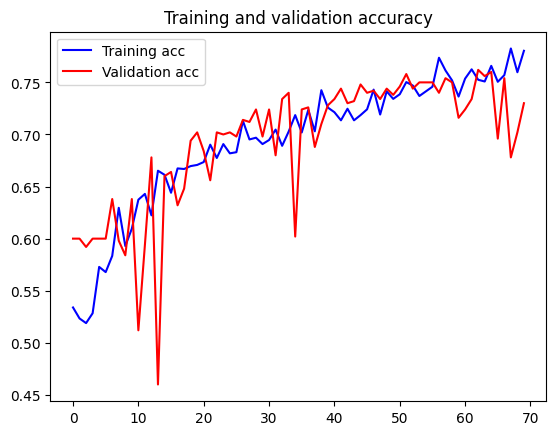

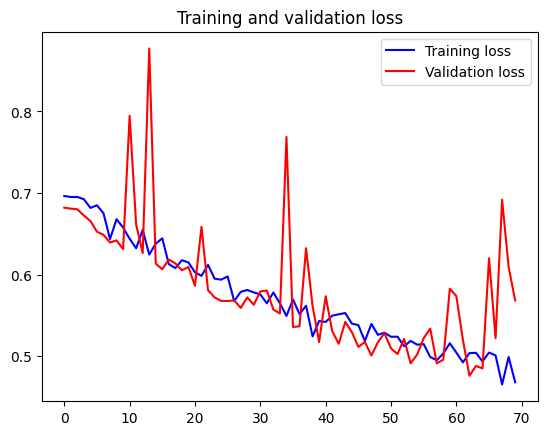

In [10]:
import matplotlib.pyplot as plt

acc2 = history.history["acc"]
val_acc2 = history.history["val_acc"]
loss2 = history.history["loss"]
val_loss2 = history.history["val_loss"]

epochs = range(len(acc2))

plt.plot(epochs, acc2, "b", label="Training acc")
plt.plot(epochs, val_acc2, "r", label="Validation acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss2, "b", label="Training loss")
plt.plot(epochs, val_loss2, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [11]:
import os.path

path, dirs, files = next(os.walk("/Users/cedar/Downloads/HW8/history_files"))
file_count = len(files)
save_path = "history_files/"
name_of_file = "model_"
completeName = os.path.join(save_path, name_of_file + str(file_count) + ".h5")
# model_DA.save('history_files/skin_cancer_03.h5')
print(completeName)
model_DA.save(completeName)

history_files/model_20.h5


In [12]:
# • Use any (as many) techniques covered in class
# • At least, for each model introduced
#    CHECK - Validation graphs (accuracy and loss)
#    CHECK - model.evaluate(…) to test (140+127=267) test images using the trained model. Must display test accuracy
#    CHECK - batch of all 267 test images ONCE. 
#    CHECK - Must use m.evaluate(test_generator, steps = 1), only ONCE. 
#    CHECK - Shuffle for DA must be false. https://keras.io/api/preprocessing/image/
#    Display some images that failed in the classification with proper labels (e.g. false positive or false negative)
# • Compare and summarize your results. 
# • Best test accuracy
# • Upload hw8_yourname.ipynb file on Canvas

In [13]:
# Run the test dataset to find the accuracy
test_loss, test_acc = model_DA.evaluate(test_generator, steps=1)  # generator will get both data and label
print(f"test acc: {test_acc*100.0:.2f}%")

1/1 [==============================] - 0s 243ms/step - loss: 0.5570 - acc: 0.7528
test acc: 75.28%


1/1 [==============================] - 0s 223ms/step


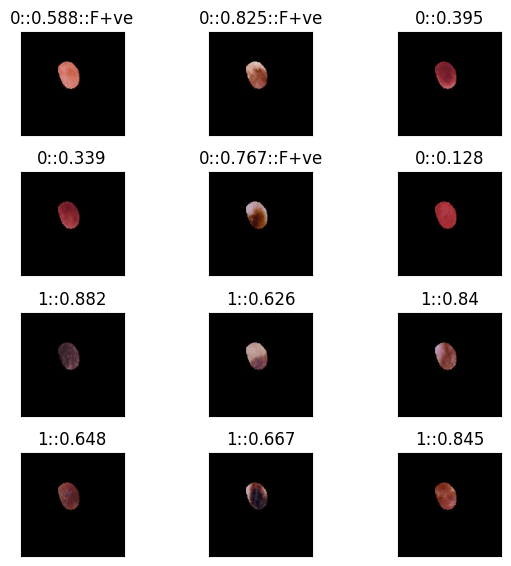

In [14]:
# Plot the results, actual v/s model confidence
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
images = test_generator[0][0]
labels = test_generator[0][1]
results = model_DA.predict(test_generator)
for i in range(12):
    plt.subplot(4, 3, i + 1)
    i = i + 134  # offset for un-shuffled dataset
    plt.tight_layout()
    plt.imshow(images[i])
    actual = int(labels[i])
    predicted = results[i][0]
    predicted = round(float(predicted), 3)
    title = f"{actual}::{predicted}"
    if actual - predicted < -0.5:  # false positive or false negative
        title = f"{actual}::{predicted}::F+ve"
    if actual - predicted > 0.5:
        title = f"{actual}::{predicted}::F-ve"
    plt.title(title)
    plt.xticks([])
    plt.yticks([])

In [15]:
experiment.end()  # CometML stop logging

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/aeolus96/hw8-skin-cancer-classification/0ff6ed113e3f4b27953d9c6c061995dd
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     acc [70]                  : (0.5189098715782166, 0.7825361490249634)
COMET INFO:     batch_acc [700]           : (0.0, 1.0)
COMET INFO:     batch_loss [700]          : (0.16902504861354828, 1.8139936923980713)
COMET INFO:     epoch_duration [70]       : (3.2105662089998077, 5.4289273750000575)
COMET INFO:     loss [70]                 : (0.465151846408844, 0.6962876915931702)
COMET INFO:     val_acc [70]              : (0.46000000834465027, 0.7620000243186951)
COMET INFO:     val_loss [70]           